In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [184]:
def preprocess_import_data(df):
    """この関数は、読み込んだデータを整形して、列名を変更する関数です.
    
    params:
        df: 読み込んだDataFrame
        
    Return:
        df: データ整形後のDataFrame
    """
    df.drop('Unnamed: 0', axis=1, inplace=True)
    # 予測に不要な特徴量を削除する
    # 実施検査日、study_date, accessionno, 患者ID, プリセット名称は削除
    drop_list = ['実施検査日(YYYYMMDD)', 'study_date', 'ACCESSIONNO', '患者ID']
    df.drop(drop_list, axis=True, inplace=True)
    
    # column名を変更する
    df.rename(columns={'検査時年齢': 'age', '性別': 'gender', '身長（ｃｍ）': 'height_cm', '体重（ｋｇ）': 'weight_kg',
                       '依頼科名称': 'department', '入院病棟名称': 'hospital_ward', '実施検査室名称': 'room', '撮影機種': 'modality', 
                       '部位名称': 'scan_area', '検査方法': 'scan_method', 'プリセット名称': 'preset'}, inplace=True)
    # 予測に使う装置
    df.query('modality == "Revolution"', inplace=True)
    
    # 年代のカラムを追加
    df['ages'] = np.floor(df['age']/10) * 10
    
    # 現状ではroom, modalityは１つだけを想定しているので、dropする。
    df.drop(['room', 'modality', 'kV', 'rotation_time'], axis=1, inplace=True)

    # hospital_wardのNaNは'外来'を意味する
    df.loc[df['hospital_ward'].isna(), 'hospital_ward'] = '外来'
    
    df.reset_index(inplace=True)
    # df.drop(['index', 'kV', 'rotation_time'], axis=1, inplace=True)
    

In [185]:
df = pd.concat([pd.read_excel('./scan_data/202109_all_scan_data.xlsx'), 
                pd.read_excel('./scan_data/202110_all_scan_data.xlsx'),
                pd.read_excel('./scan_data/202111_all_scan_data.xlsx'),
                pd.read_excel('./scan_data/202112_all_scan_data.xlsx')])
preprocess_import_data(df)

In [186]:
df.drop(index=[394, 37, 87, 634, 2126, 976, 1484], inplace=True)

In [187]:
# 身長と体重が怪しいデータを抽出する
# 外来の救急科、枠外のオーダ
df_unknown_height_weight = df[(df['department'] == '救急科') & (df['hospital_ward'] == '外来')]
len(df_unknown_heigh_weight)

1001

In [188]:
# 身長と体重をnp.nanにimputeする
df_unknown_height_weight.loc[:, 'height_cm'] = np.nan
df_unknown_height_weight.loc[:, 'weight_kg'] = np.nan

/tmp/ipykernel_690/355158159.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unknown_height_weight.loc[:, 'height_cm'] = np.nan
/tmp/ipykernel_690/355158159.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unknown_height_weight.loc[:, 'weight_kg'] = np.nan


In [189]:
df_known_height_weight = df[~(df['department'] == '救急科') | ~(df['hospital_ward'] == '外来')]

In [190]:
len(df_known_height_weight)

1837

In [191]:
len(df)

2838

In [202]:
df.head(2)

,index,age,gender,height_cm,weight_kg,adult_child,department,hospital_ward,scan_area,preset,scan_method,scan_protocol,scan_series,mA,CTDI,DLP,ages
0,0,72,M,170.0,83.0,成人,救急科,外来,胸部〜骨盤CT,256列 【枠外】胸〜骨盤CT（造影適宜）,造影,5.7 P+CE Chest-Pelvis Routine,1: Plain,366.41,16.64,1352.35,70.0
1,1,72,M,170.0,83.0,成人,救急科,外来,胸部〜骨盤CT,256列 【枠外】胸〜骨盤CT（造影適宜）,造影,5.7 P+CE Chest-Pelvis Routine,2: CE,366.41,16.61,1349.55,70.0


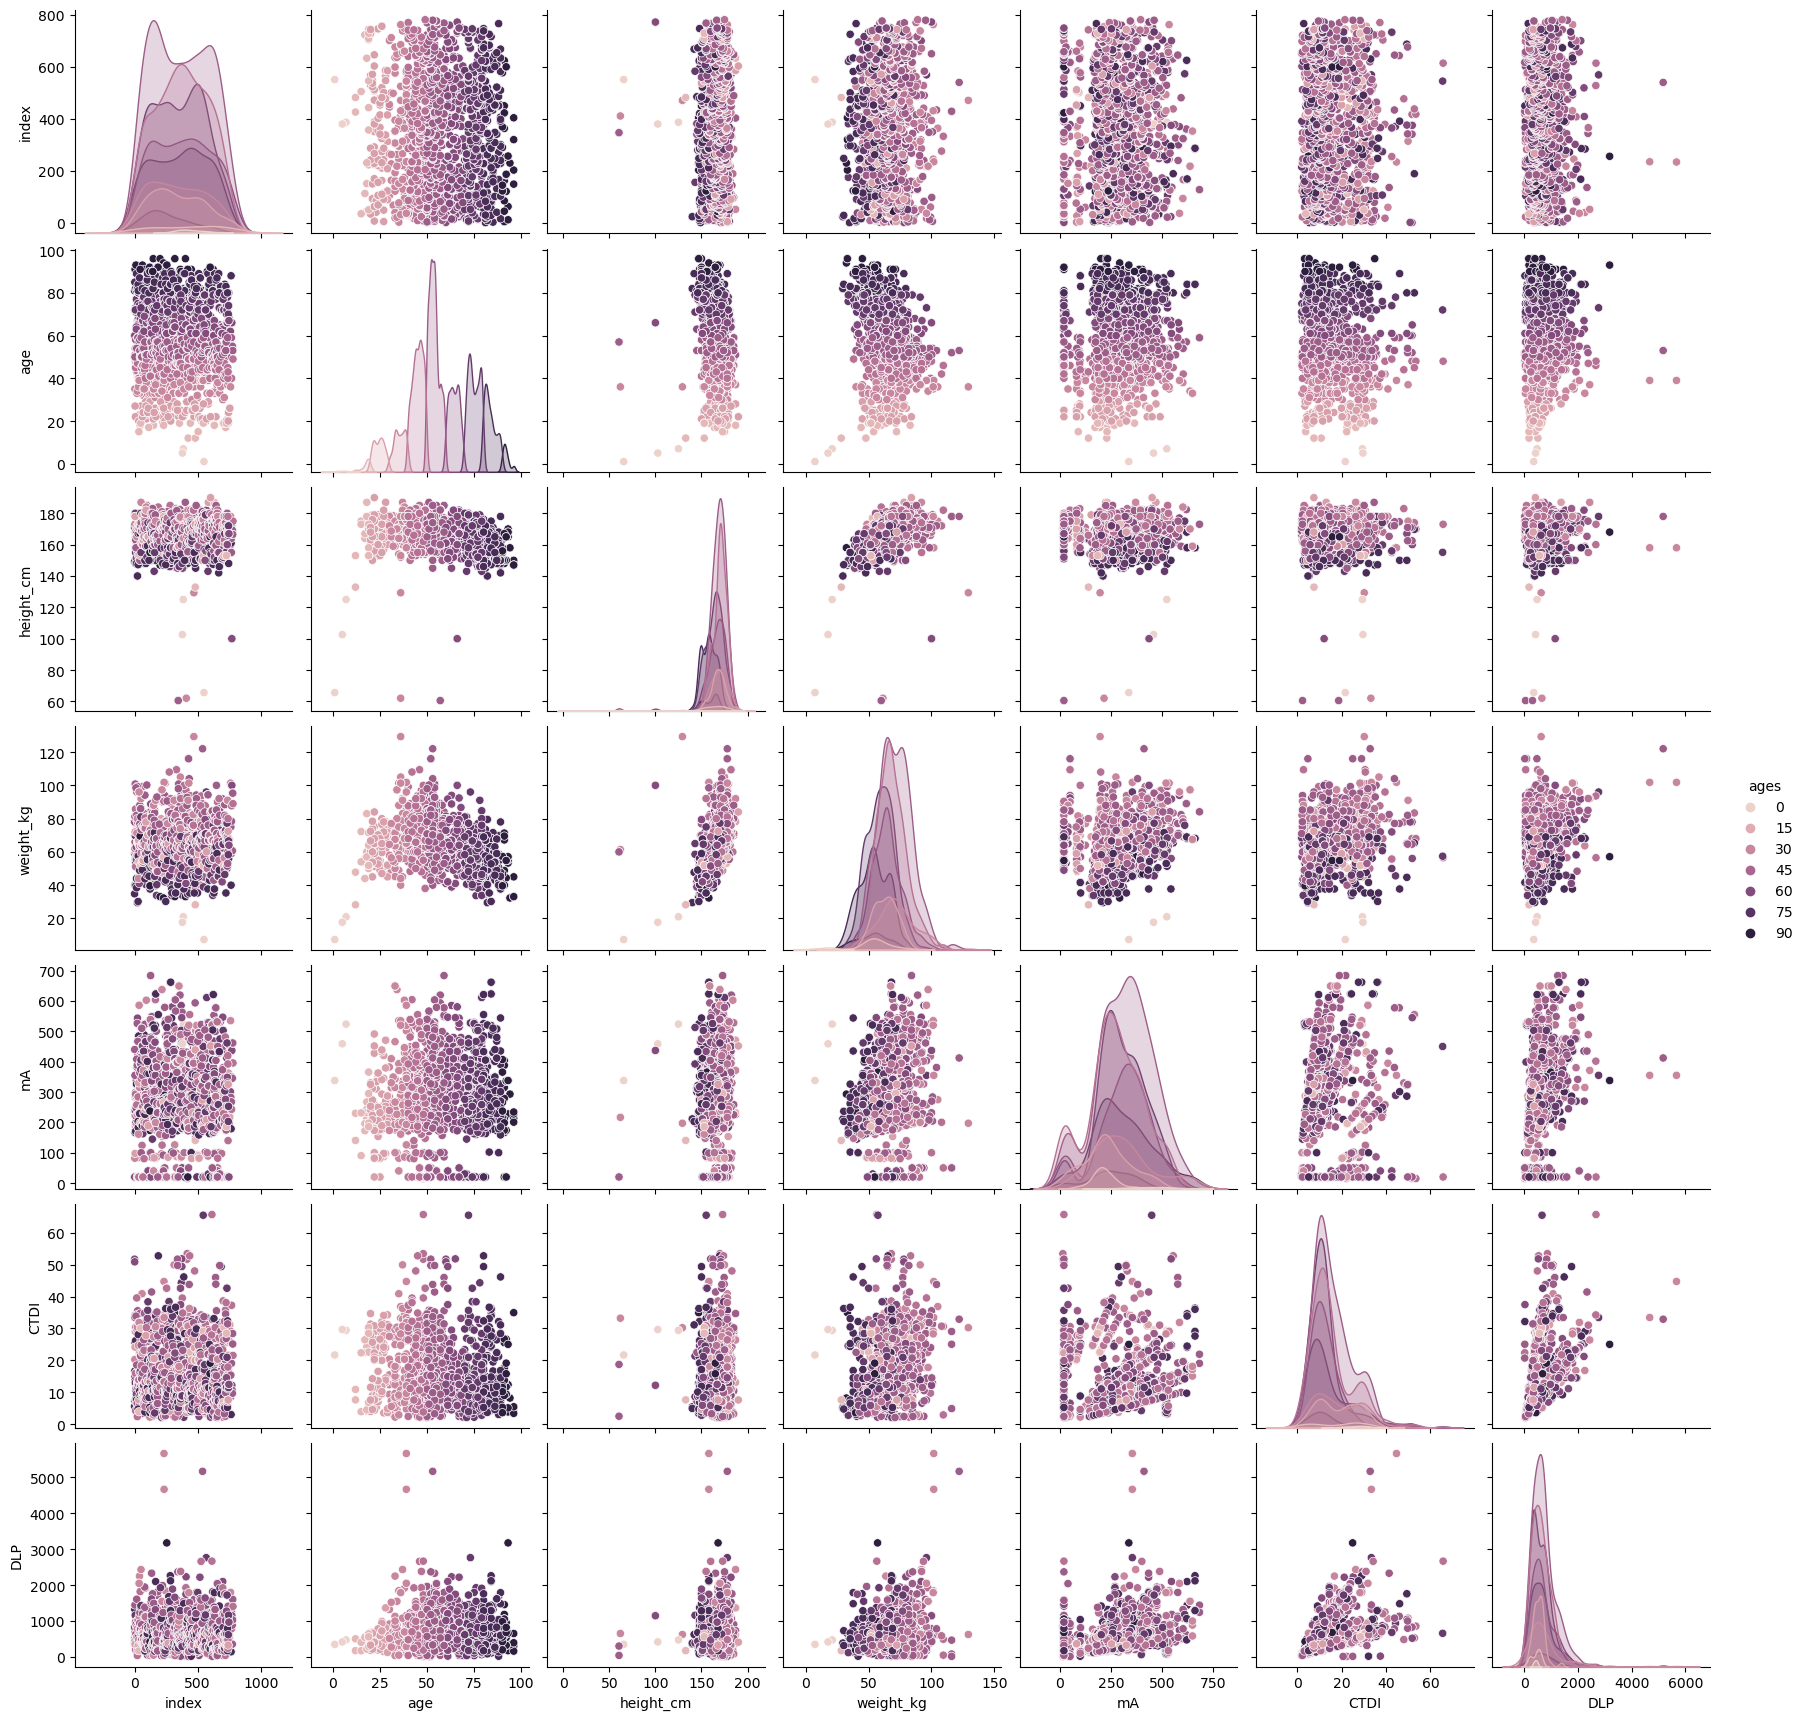

In [192]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.pairplot(df_known_height_weight, hue='ages')

In [193]:
df_known_height_weight.describe()

,index,age,height_cm,weight_kg,mA,CTDI,DLP,ages
count,1837.000000,1837.000000,1837.000000,1837.000000,1837.000000,1837.000000,1837.000000,1837.000000
mean,361.916712,57.710942,166.165814,64.885008,296.830533,15.083892,658.204518,53.418617
std,213.863761,17.343033,10.315760,13.643009,134.813858,9.208680,449.633202,17.494647
min,0.000000,1.000000,60.500000,7.310000,15.000000,2.070000,10.350000,0.000000
25%,173.000000,46.000000,160.000000,55.700000,211.440000,8.910000,356.790000,40.000000
50%,361.000000,55.000000,167.600000,65.000000,293.280000,12.280000,586.310000,50.000000
75%,539.000000,72.000000,173.000000,73.000000,386.820000,19.290000,818.830000,70.000000
max,780.000000,96.000000,190.000000,129.300000,683.810000,65.720000,5668.510000,90.000000


### 身長体重を予測する

* 身長と体重が既知のデータを分割する
* 懸案事項として、頭部系のCTは除外した方が当たり易いか？

* 1. 年齢毎に人口統計データから平均値を代入する関数を作成する
* 2. 現在あるデータの中央値の値を代入する
* 3. 現在あるデータの平均値を代入する
* 4. KNNを使って回帰を作成する


In [200]:
df_known_height_weight.groupby(['ages', 'gender']).describe()[['height_cm', 'weight_kg']]

height_cm                                                        \
                count        mean        std    min      25%    50%     75%   
ages gender                                                                   
0.0  F            1.0   65.600000        NaN   65.6   65.600   65.6   65.60   
     M            2.0  113.800000  15.839192  102.6  108.200  113.8  119.40   
10.0 F            7.0  152.271429   9.356765  132.9  153.000  153.0  155.50   
     M           12.0  171.166667   8.375650  153.0  167.000  171.5  175.50   
20.0 F           25.0  159.872000   5.257655  150.0  155.000  161.0  165.00   
     M           67.0  171.164179   6.275486  156.0  167.000  171.0  174.00   
30.0 F           18.0  158.350000   9.256111  129.3  155.250  160.0  160.75   
     M          100.0  169.592000  12.767190   62.0  165.000  170.0  175.00   
40.0 F           58.0  159.391379   5.209987  150.0  155.000  160.0  163.00   
     M          295.0  171.811525   5.662197  158.0  168.300  171.0  176.00   
50.0 F           73.0  159.060274   4.179239  145.0  156.000  159.0  162.00   
     M          403.0  170.170471   9.742613   60.5  166.450  170.0  175.00   
60.0 F           47.0  155.904255   4.129899  150.0  152.000  156.0  160.00   
     M          187.0  169.018717   9.476401  100.0  166.450  170.0  175.00   
70.0 F           89.0  153.182022   4.701706  143.0  150.000  153.0  156.00   
     M          222.0  168.093694   5.886364  157.0  164.075  167.0  172.00   
80.0 F          105.0  152.615238   5.271199  140.0  148.000  151.0  157.80   
     M           91.0  164.373626   5.472392  152.0  159.100  164.7  168.00   
90.0 F           16.0  151.687500   3.961797  147.0  149.500  150.0  155.25   
     M           19.0  165.600000   1.540563  163.4  165.000  165.0  165.00   

                   weight_kg                                              \
               max     count       mean        std    min     25%    50%   
ages gender                                                                
0.0  F        65.6       1.0   7.310000        NaN   7.31   7.310   7.31   
     M       125.0       2.0  19.350000   2.333452  17.70  18.525  19.35   
10.0 F       163.0       7.0  49.171429   9.668112  28.20  50.900  51.80   
     M       187.0      12.0  60.329167  11.052611  44.00  53.750  58.50   
20.0 F       166.0      25.0  52.704000   4.261013  45.00  51.000  53.80   
     M       190.0      67.0  66.932836   7.243208  51.20  62.125  66.60   
30.0 F       178.0      18.0  56.850000  20.908716  40.00  45.200  51.35   
     M       187.0     100.0  74.792500  12.960052  48.70  66.700  71.60   
40.0 F       174.0      58.0  58.777586  11.796186  38.05  54.000  55.70   
     M       185.0     295.0  70.400169  10.557416  53.80  63.950  68.00   
50.0 F       168.0      73.0  57.623973  10.778780  40.00  50.000  54.00   
     M       187.0     403.0  73.021216  12.226506  47.10  64.000  73.00   
60.0 F       164.0      47.0  55.706383   9.421123  41.00  51.000  54.00   
     M       182.0     187.0  66.537433  10.966611  38.90  60.950  65.00   
70.0 F       164.0      89.0  50.830899   8.963377  33.70  45.300  50.00   
     M       180.0     222.0  62.808784   9.695681  40.30  56.200  63.00   
80.0 F       163.0     105.0  49.797619  11.603494  29.50  40.300  49.10   
     M       178.0      91.0  58.897802   9.520259  38.40  52.400  56.20   
90.0 F       158.0      16.0  42.940625   8.590774  32.30  37.975  40.00   
     M       170.0      19.0  61.052632   7.152417  53.30  54.800  57.10   

                              
                 75%     max  
ages gender                   
0.0  F        7.3100    7.31  
     M       20.1750   21.00  
10.0 F       51.8000   58.80  
     M       65.9000   83.00  
20.0 F       55.0000   60.00  
     M       71.9000   84.00  
30.0 F       56.0000  129.30  
     M       80.7125  105.00  
40.0 F       63.5000   93.60  
     M       76.0750  109.40  
50.0 F       62.0000   98.50  
     M     

In [206]:
from sklearn.model_selection import train_test_split

In [219]:
df_known_height_weight.drop('index', axis=1 ,inplace=True)

/tmp/ipykernel_690/2030232213.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_known_height_weight.drop('index', axis=1 ,inplace=True)


[      age gender  height_cm  weight_kg adult_child department hospital_ward  \
 1290   83      M      168.0       52.4          成人      消化器内科            外来   
 794    80      F      147.5       51.4          成人      循環器内科            外来   
 911    79      F      149.0       57.7          成人      消化器内科            外来   
 302    81      M      171.0       53.0          成人      消化器内科            ５西   
 1050   74      M      169.2       51.6          成人      循環器内科            外来   
 ...   ...    ...        ...        ...         ...        ...           ...   
 835    36      M      173.0       65.0          成人      消化器内科            外来   
 1216   79      M      172.0       59.0          成人      消化器内科            外来   
 1653   49      M      182.0       76.0          成人      消化器内科            外来   
 559    52      M      165.0       93.9          成人      循環器内科            外来   
 684    30      F      178.0       76.0          成人      総合診療科            外来   
 
        scan_area               preset

In [217]:
df_known_height_weight

,index,age,gender,height_cm,weight_kg,adult_child,department,hospital_ward,scan_area,preset,scan_method,scan_protocol,scan_series,mA,CTDI,DLP,ages
0,2,85,M,171.0,58.9,成人,循環器内科,外来,胸部〜骨盤CT,256列 【枠外】胸〜骨盤CT（単純）,単純,5.7 P+CE Chest-Pelvis Routine,1: Plain,234.59,16.66,1320.20,80.0
1,3,91,F,150.0,40.0,成人,脳神経外科,外来,脳CT,256列 【枠外】脳・頭部CT（単純）,単純,1.7 Brain Head Routine TFI-H,1: Helical,166.63,25.56,538.61,90.0
2,4,91,F,150.0,40.0,成人,脳神経外科,外来,脳CT,256列 【枠外】脳・頭部CT（単純）,単純,1.7 Brain Head Routine TFI-H,2: HelicalC2,166.63,25.55,538.34,90.0
3,8,73,F,155.0,55.0,成人,呼吸器内科,外来,胸部CT,256列 胸部CT（単純）,単純,5.1 QQ Chest Routine,1: Plain,298.35,4.99,230.85,70.0
4,11,93,M,165.0,53.3,成人,心血管外科,外来,腹部〜骨盤CT,256列 腹部骨盤CT（単純）,単純,6.2 Abdomen-Pelvis Routine,1: Plain,227.47,12.37,646.48,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1832,2840,74,M,172.0,66.6,成人,総合診療科,５西,胸部〜骨盤CT,256列 【枠外】胸〜骨盤CT（造影適宜）,造影,5.7 P+CE Chest-Pelvis Routine,1: Plain,252.78,11.34,1102.65,70.0
1833,2841,74,M,172.0,66.6,成人,総合診療科,５西,胸部〜骨盤CT,256列 【枠外】胸〜骨盤CT（造影適宜）,造影,5.7 P+CE Chest-Pelvis Routine,2: CE,252.78,11.46,1160.12,70.0
1834,2842,67,M,167.0,64.0,成人,消化器内科,外来,胸部〜骨盤CT,256列 胸〜骨盤CT（造影適宜）,造影,5.13 Aorta CTA Routine SmartPrep,1: Plain,20.03,12.48,969.27,60.0
1835,2843,67,M,167.0,64.0,成人,消化器内科,外来,胸部〜骨盤CT,256列 胸〜骨盤CT（造影適宜）,造影,5.13 Aorta CTA Routine SmartPrep,2: CTA,20.03,12.44,966.40,60.0
